# signMNIST 분류 인공지능 모델 구현

- signMNIST: 수화 이미지
- shape: 28x28
- class: 24
  > 0-25 (A-Z) 인데 J(9)와 Z(25)가 없음

1. 훈련 이전에 이미지화해서 몇장 그려보기
2. CNN 모델을 구성해서 훈련시키기

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

In [2]:
import numpy as np
import pandas as pd

from tensorflow.keras import layers, models, optimizers, utils, datasets
# from notebooks.utils import display

## 파라미터

In [3]:
NUM_CLASSES = 24

## 데이터 불러오기

In [153]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

In [154]:
# 데이터 확인
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [155]:
train.shape

(27455, 785)

In [156]:
test.shape

(7172, 785)

In [157]:
x_train = train.drop(['label'], axis = 1)
y_train = train['label']

x_test = test.drop(['label'], axis = 1)
y_test = test['label']

In [158]:
x_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [159]:
y_train.value_counts()

17    1294
16    1279
11    1241
22    1225
5     1204
18    1199
14    1196
3     1196
19    1186
23    1164
8     1162
20    1161
13    1151
2     1144
0     1126
24    1118
10    1114
6     1090
15    1088
21    1082
12    1055
7     1013
1     1010
4      957
Name: label, dtype: int64

In [160]:
# 클래스 레이블 매핑
import string

alphabet = string.ascii_uppercase

y_train = [alphabet[label] for label in y_train if label < len(alphabet)]
y_train = pd.Series(y_train)

y_test = [alphabet[label] for label in y_test if label < len(alphabet)]
y_test = pd.Series(y_test)

In [161]:
y_train.value_counts()

R    1294
Q    1279
L    1241
W    1225
F    1204
S    1199
O    1196
D    1196
T    1186
X    1164
I    1162
U    1161
N    1151
C    1144
A    1126
Y    1118
K    1114
G    1090
P    1088
V    1082
M    1055
H    1013
B    1010
E     957
dtype: int64

In [162]:
len(set(y_train))

24

## 데이터 이미지화

In [163]:
x_train = x_train.values.reshape(-1, 28, 28)
x_test = x_test.values.reshape(-1, 28, 28)

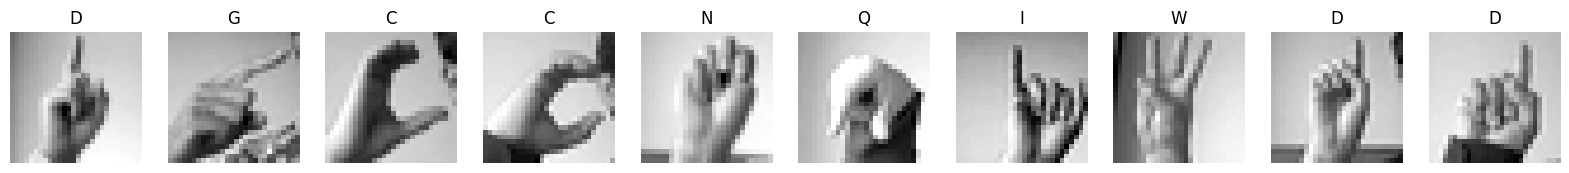

In [164]:
import matplotlib.pyplot as plt

num_images = 10
fig, ax = plt.subplots(1, num_images, figsize=(20, 2))

for i in range(num_images):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(y_train[i])

plt.show()

### 데이터 전처리

In [165]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 사용하여 문자열을 정수로 매핑
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = pd.Series(y_train)

y_test = label_encoder.fit_transform(y_test)
y_test = pd.Series(y_test)

In [166]:
y_train.value_counts()

16    1294
15    1279
10    1241
21    1225
5     1204
17    1199
13    1196
3     1196
18    1186
22    1164
8     1162
19    1161
12    1151
2     1144
0     1126
23    1118
9     1114
6     1090
14    1088
20    1082
11    1055
7     1013
1     1010
4      957
dtype: int64

In [167]:
# x_train = x_train.astype("float32") / 255.0
# x_test = x_test.astype("float32") / 255.0
x_train = np.divide(x_train, 255.)
x_test = np.divide(x_test,  255.)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [168]:
np.min(x_train), np.max(x_train)

(0.0, 1.0)

## 모델 만들기

In [169]:
input_layer = layers.Input((28, 28, 1))

x = layers.Conv2D(filters=4, kernel_size=3, strides=1, padding="same", activation="relu")(input_layer)

x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=8, kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Flatten()(x)

x = layers.Dense(48, activation="relu")(x)
x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 7, 7, 16)          1168

## 모델 훈련

In [170]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [175]:
model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10
773/773 [==============================] - 4s 5ms/step - loss: 0.4473 - accuracy: 0.8571 - val_loss: 0.4301 - val_accuracy: 0.8638
Epoch 2/10
773/773 [==============================] - 4s 5ms/step - loss: 0.4256 - accuracy: 0.8665 - val_loss: 0.4015 - val_accuracy: 0.8824
Epoch 3/10
773/773 [==============================] - 4s 5ms/step - loss: 0.4039 - accuracy: 0.8725 - val_loss: 0.3945 - val_accuracy: 0.8886
Epoch 4/10
773/773 [==============================] - 4s 5ms/step - loss: 0.3849 - accuracy: 0.8796 - val_loss: 0.3818 - val_accuracy: 0.8827
Epoch 5/10
773/773 [==============================] - 4s 5ms/step - loss: 0.3657 - accuracy: 0.8853 - val_loss: 0.3477 - val_accuracy: 0.8984
Epoch 6/10
773/773 [==============================] - 4s 5ms/step - loss: 0.3483 - accuracy: 0.8929 - val_loss: 0.3226 - val_accuracy: 0.9020
Epoch 7/10
773/773 [==============================] - 4s 5ms/step - loss: 0.3305 - accuracy: 0.8969 - val_loss: 0.3284 - val_accuracy: 0.8984
Epoch 

## 모델 평가

In [176]:
model.evaluate(x_test, y_test)

225/225 [==============================] - 1s 3ms/step - loss: 0.7809 - accuracy: 0.7893


[0.7808552384376526, 0.7893195748329163]

### 예측 결과 확인

In [177]:
# 시험 및 훈련 데이터셋에 예측 진행
train_pred = model.predict(x_train)
train_pred = np.argmax(train_pred, axis=1)

test_pred = model.predict(x_test)
test_pred = np.argmax(test_pred, axis=1)

In [178]:
y_train[2]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [179]:
train_pred[2]

2

In [180]:
y_train = np.argmax(y_train, axis=1)

In [181]:
# 성능 평가를 위해 혼잡 행렬 확인
from sklearn.metrics import confusion_matrix

train_conf = confusion_matrix(y_true=y_train, y_pred=train_pred)

In [182]:
train_conf.shape

(24, 24)

In [183]:
# 알파벳을 배열로 만들기
alphabet = list(string.ascii_uppercase)

# J와 Z 제외
alphabet_excluded = [char for char in alphabet if char not in {'J', 'Z'}]
print(alphabet_excluded)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


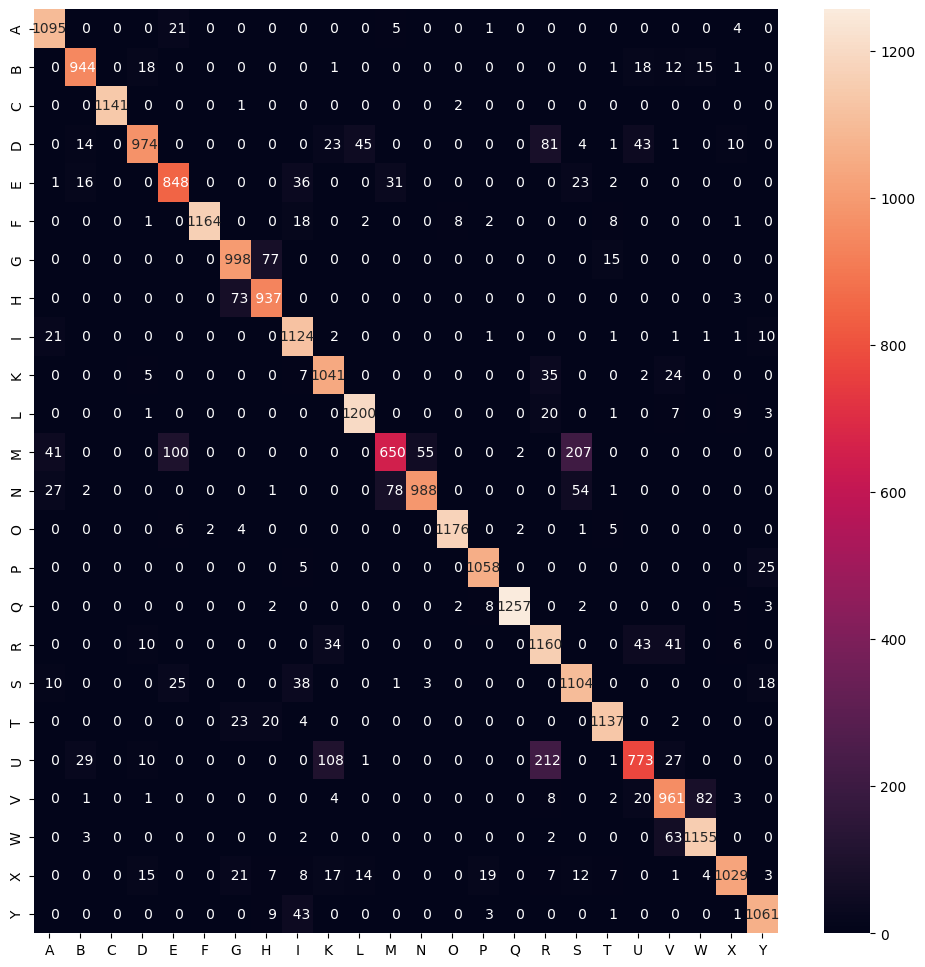

In [184]:
import seaborn as sns
import matplotlib as mpl

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(train_conf, annot=True, fmt='4d', ax=ax)
ax.set(xticklabels=alphabet_excluded, yticklabels=alphabet_excluded)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [185]:
y_test = np.argmax(y_test, axis=1)

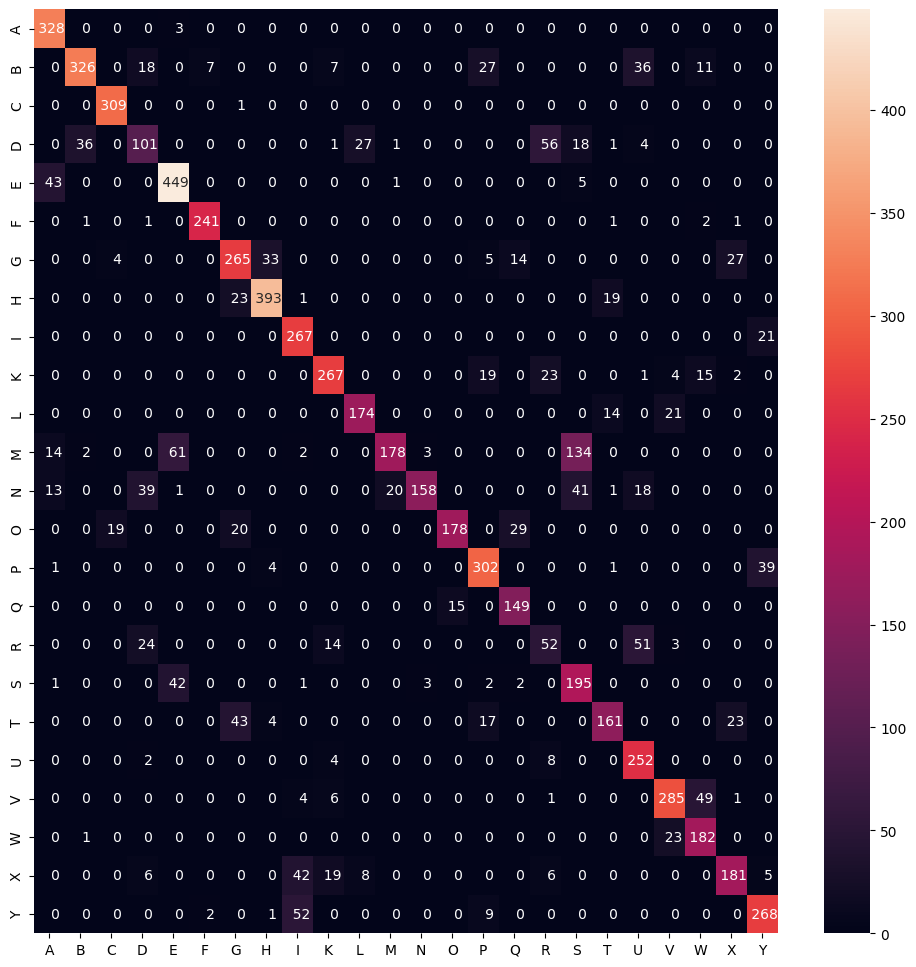

In [186]:
# 시험데이터 혼잡 행렬 확인
test_conf = confusion_matrix(y_true=y_test, y_pred=test_pred)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(test_conf, annot=True, fmt='4d', ax=ax)
ax.set(xticklabels=alphabet_excluded, yticklabels=alphabet_excluded)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### 혼잡행렬로 알아볼 수 있는 것
![](https://github.com/SPAI-Lab/GenerativeAI_Study/assets/59556524/935da6b6-a4be-472e-86b6-cbfa2ef0e9e1)
- `M`을 `S`로 잘못 예측하는 경우가 상당수를 차지
- 주먹 모양인 `A`, `E`, `M`, `N`, `S`를 잘못 예측하는 경우가 많음

In [187]:
# 틀린 데이터 가져오기
incorr_mask = (y_test != test_pred)
incorr_x = x_test[incorr_mask]
incorr_y = y_test[incorr_mask]
incorr_y_hat = test_pred[incorr_mask]

In [188]:
x_test.shape, incorr_x.shape

((7172, 28, 28), (1511, 28, 28))

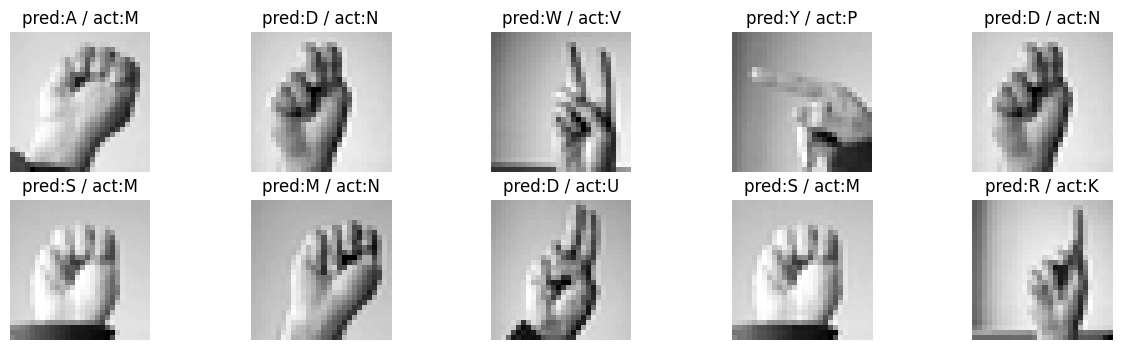

In [191]:
# 틀린 데이터 시각화
num_samples = 10
rand_idx = np.random.choice(np.arange(incorr_x.shape[0]), 10)
samples = incorr_x[rand_idx]
preds = incorr_y_hat[rand_idx]
labels = incorr_y[rand_idx]

num_images_per_row = 5
num_rows = 2
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 4))

for i in range(num_rows):
    for j in range(num_images_per_row):
        index = i * num_images_per_row + j
        axes[i, j].imshow(samples[index], cmap='gray')
        axes[i, j].set_title(f'pred:{alphabet_excluded[preds[index]]} / act:{alphabet_excluded[labels[index]]}')
        axes[i, j].axis('off')

plt.show()